In [754]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series


from sktime.forecasting.model_selection import temporal_train_test_split

In [790]:
df = pd.read_excel(r'C:\Users\User\Desktop\Прога\Питон\BST_DataSet.xlsx')

In [791]:
df = df.iloc[:-1, :-3]

In [792]:
df.columns = ['date', 'dep_incr', 'ofz_profit', 'key_rate', 'dep_rate_usd', 'dep_rate_rub', 'oil_price', 'cpi', 'm0', 'm2', 'dollar_rate', 'nominal_wage']

In [793]:
##c сайта ростата добавим данные по приросту вкладов за 2017 год
df.iloc[72:,1] = [18322102-18476652, 18581633-18322102, 18649233-18581633, 18811671-18649233,18910388-18811671, 19287112-18910388,  19263079-19287112, 19284958-19263079,19350146-19284958,19408164-19350146, 19629278-19408164, 20642614-19629278]

In [794]:
df.isnull().sum()

date            0
dep_incr        0
ofz_profit      0
key_rate        0
dep_rate_usd    0
dep_rate_rub    0
oil_price       0
cpi             0
m0              0
m2              0
dollar_rate     0
nominal_wage    0
dtype: int64

В данных нет пропущенных значений.

<b>Построим динамику основных показателей</b>

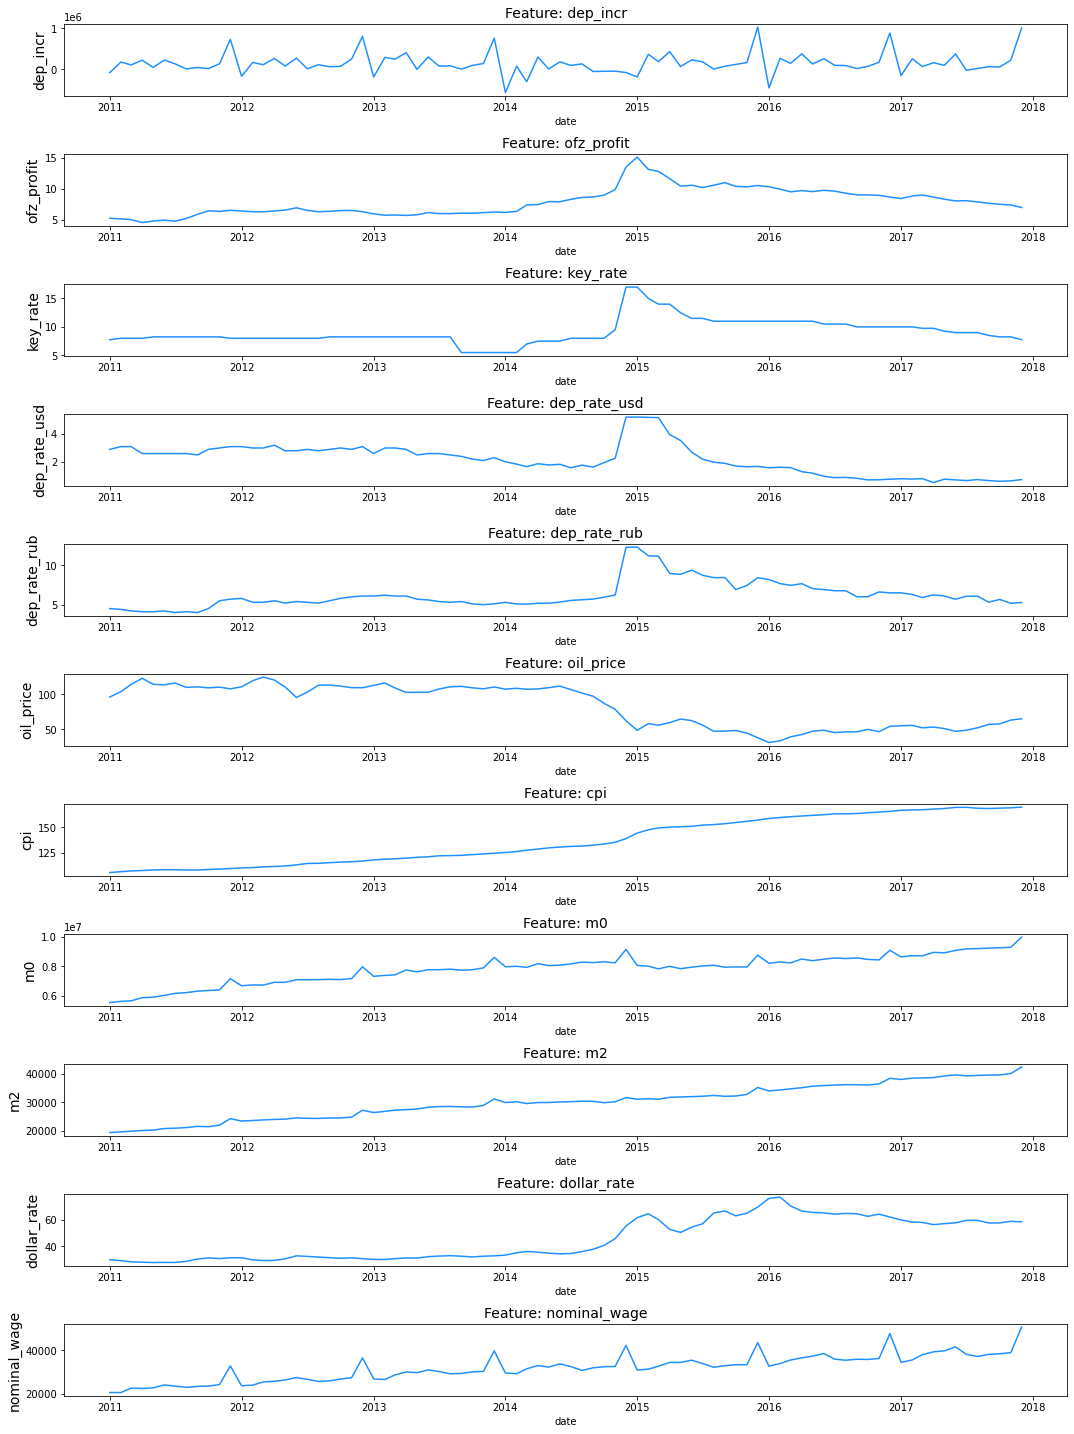

In [613]:
fig, ax = plt.subplots(11, 1, figsize=(15, 20))

for i, col in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[col], ax=ax[i], color='dodgerblue')
    ax[i].set_title(f'Feature: {col}', fontsize=14)
    ax[i].set_ylabel(ylabel=col, fontsize=14)
fig.tight_layout(pad=1.0)

# Baseline

<b>В качестве бейзлана будем использовать модель auto SARIMA, чтобы подобрать необзодимые параметры. Оставим только ряд с приростом депозитов.</b>

Для того, чтобы использовать эту модель необходимо сделать проверку на стационарность, так как это ее главная предпосылка

In [614]:
##Основные метрики
from sklearn.metrics import mean_absolute_error


def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)
def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))
def mase(y_true, y_pred, y_train): ## аналог R^2 сравнивает найвный прогноз с прогнозом модели и показывает насколько он лучше
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

Для определения параметров теста посмотрим на динамику ряда

In [615]:
baseline = df.iloc[:,:2]
baseline.head()

,date,dep_incr
0,2011-01-01,-79049.0
1,2011-02-01,180475.0
2,2011-03-01,106845.0
3,2011-04-01,224890.0
4,2011-05-01,45856.0


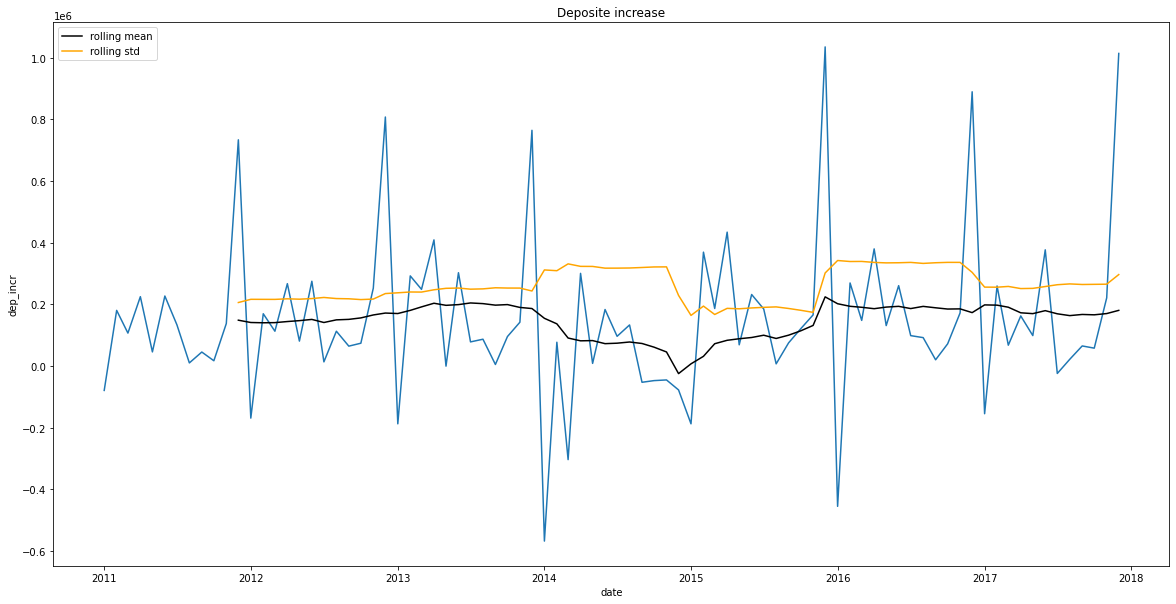

In [616]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
rolling_window = 12 ##считаем среднее для каждого года

sns.lineplot(x=baseline['date'], y=baseline['dep_incr'], ax=ax)
sns.lineplot(x=baseline['date'], y=baseline['dep_incr'].rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
sns.lineplot(x=baseline['date'], y=baseline['dep_incr'].rolling(rolling_window).std(), ax=ax, color='orange', label='rolling std')
ax.set_title('Deposite increase');

Вихзуально можно заметить что мы имеем константные среднее и стандартное отклонение. Все скачки происходят из за того, что данных слишком мало и мы взяли достаточно маленькое окно

<b>Разложим ряд на составляющие, чтобы проверить, есть ли в нем тренд</b>

<ipython-input-617-ba2b0979b454>:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(baseline['dep_incr'], freq=12, model='additive', extrapolate_trend='freq')


Text(0, 0.5, 'Residual')

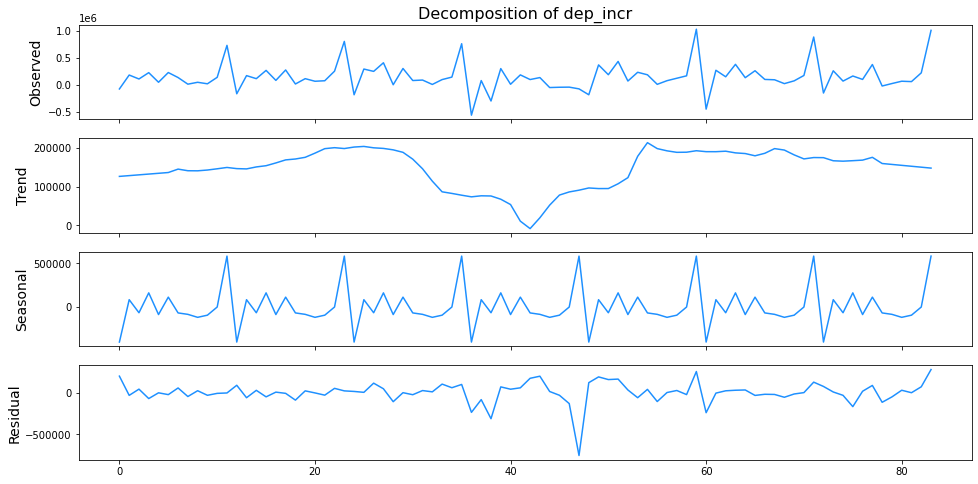

In [617]:
for_decomp = pd.DataFrame()
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(baseline['dep_incr'], period=12, model='additive', extrapolate_trend='freq')
for_decomp["dep_incr_trend"] = decomp.trend
for_decomp["dep_incr_seasonal"] = decomp.seasonal

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(baseline['dep_incr'], freq=12, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of dep_incr', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)
    
res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)



На графике виден явный тренд, поэтому для тестов будем использовать спицификацию “ct” : constant trend, которая его учитывает.


Проведем два теста на стационарность:

<b>Тест Дики Фуллера</b>

Нулевая гипотеза: ряд нестационарен(есть единичный корень)

Альтернативная гипотеза: ряд стационарен(единичного корня нет)

<b>Тест KPSS</b>

Нулевая гипотеза: ряд стационарен

Альтернативная гипотеза: ряд нестационарен

In [618]:
from statsmodels.tsa.stattools import adfuller, kpss
ad_p = adfuller(baseline.set_index('date'), regression='ct', autolag='BIC')[1]

In [619]:
kp_p = kpss(baseline.set_index('date'), regression='ct')[1]

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [620]:
print('P_value для теста Дики Фуллера: {}, гипотеза о нестационарности ряда отвергается\nP_value для теста KPSS: {}, гипотеза о стационарности ряда не отвергается'.format(ad_p, kp_p))

P_value для теста Дики Фуллера: 2.169816599153258e-18, гипотеза о нестационарности ряда отвергается
P_value для теста KPSS: 0.1, гипотеза о стационарности ряда не отвергается


Оба теста подтвердили, что ряд стационарен, поэтому можем перейти к модели.

## Sarima

In [621]:
y_train = baseline.iloc[:72]
y_test = baseline.iloc[72:]

In [622]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.auto_arima(
    
    y_train.set_index('date'),
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=12,
    start_P=0, start_Q=0,
    max_P = 5, max_Q = 5,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=12
    
)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=2007.149, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=1998.263, Time=0.15 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=1997.136, Time=0.30 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : BIC=1998.646, Time=0.70 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : BIC=1998.861, Time=1.14 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : BIC=2001.935, Time=2.76 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=1995.886, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=1999.557, Time=0.37 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=2000.002, Time=0.43 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : BIC=2001.226, Time=1.28 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : BIC=2002.430, Time=1.96 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=1998.426, Time=0.31 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=1997.584, Time=0.40 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=2002.593, Time=0.59 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : BIC=inf, Time=3.09 sec


In [623]:
y_pred, pred_ci = arima_model.predict(
    n_periods=12, 
    return_conf_int=True, ##предскажем доверительные интервалы
    alpha=0.05
)

print('mape: {}\nmse: {}\nmae: {}\nmase: {}'.format(mape(y_pred, y_test.dep_incr),\
                                          mse(y_pred, y_test.dep_incr), \
                                          mae(y_pred, y_test.dep_incr), \
                                         mase(y_pred, y_test.dep_incr, y_train.dep_incr)))

mape: 59.99634731218825
mse: 30469854338.624424
mae: 116265.99360271252
mase: 0.4353268121365308


In [624]:
mase(y_pred, y_test.dep_incr, y_train.dep_incr)

0.4353268121365308

Ошибка получилась очень большой, построим график для предсказаний

In [625]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = y_test.date
df_forecast.head()

,y_pred,ci_lower,ci_upper
date,,,
2017-01-01,-141978.853161,-624903.550484,340945.844162
2017-02-01,275870.900671,-207093.949087,758835.750429
2017-03-01,89360.433398,-393644.488813,572365.355609
2017-04-01,318107.884048,-164937.030802,801152.798897
2017-05-01,83033.777468,-400051.050370,566118.605307


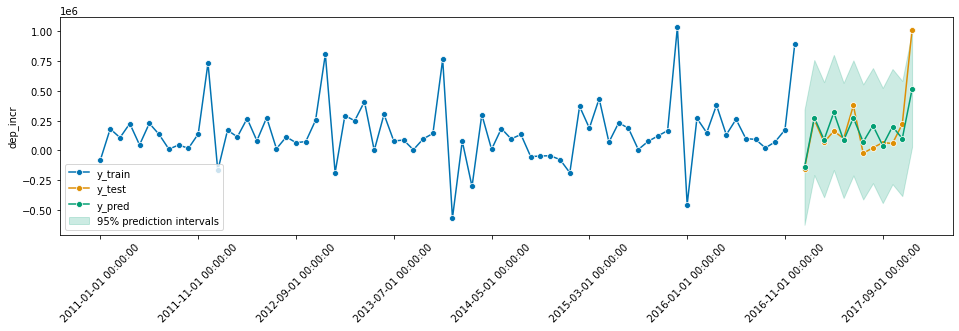

In [626]:
fig, ax = plot_series(y_train.set_index('date')['dep_incr'], y_test.set_index('date')['dep_incr'], df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');
plt.xticks(rotation=45);

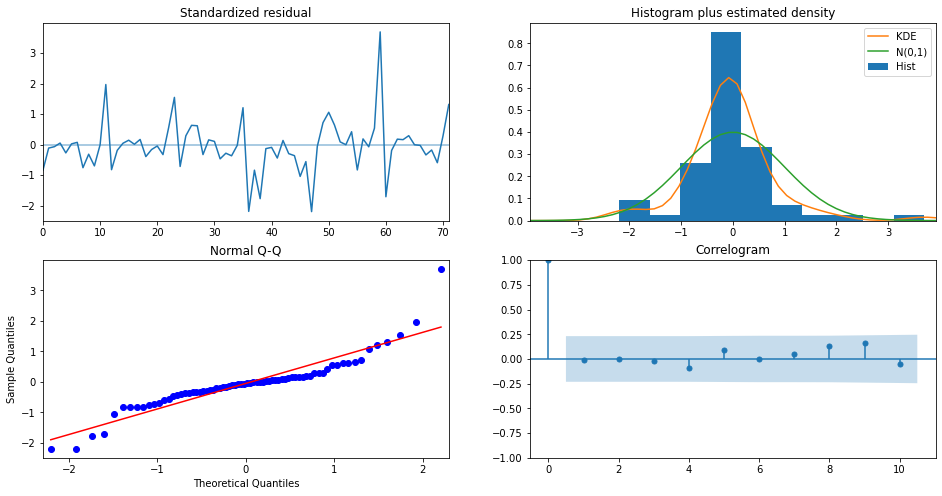

In [627]:
arima_model.plot_diagnostics(figsize=(16,8))
plt.show()

<b>Выводы:</b> остатки распределены около нуля с постоянной дисперсией-предпосылка модели не нарушается

Автокорреляции нет, все они учтены в модели-предпосылка модели не нарушается

Остатки не имеют нормального распределения-предпосылка модели нарушается


<b>Попробуем использовать преобразование бокса кокса, чтобы привести данные к нормальному виду и снова обучить нашу модель</b>

In [628]:
max_tr = abs(y_train['dep_incr'].min() - 1)##бокс кокс не работает с отрицательными значениями, поэтому прибавим ко всем данным константу



In [629]:
from pmdarima.preprocessing import BoxCoxEndogTransformer
transformed_train = pd.DataFrame()
transformed_test = pd.DataFrame()

trans = BoxCoxEndogTransformer()
transformed_train['dep_incr'] = trans.fit_transform(y_train['dep_incr'] + max_tr)[0]
transformed_test['dep_incr'] = trans.transform(y_test['dep_incr']+max_tr)[0]

transformed_train['date'] = y_train['date']
transformed_test['date'] = y_test['date']

In [630]:
arima_model = pm.auto_arima(
    
    transformed_train.set_index('date'),
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=12,
    start_P=0, start_Q=0,
    max_P = 5, max_Q = 5,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=12
    
)


 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=1463.121, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=1455.309, Time=0.32 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=1453.332, Time=0.44 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : BIC=1454.801, Time=1.08 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : BIC=1455.678, Time=1.90 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : BIC=1458.914, Time=2.93 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=1465.937, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=1459.983, Time=0.43 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=1457.423, Time=0.47 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : BIC=1458.788, Time=1.24 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : BIC=1459.882, Time=2.46 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=1470.170, Time=0.47 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=1455.760, Time=0.95 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=1459.816, Time=1.39 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : BIC=inf, Time=3.90 sec


In [631]:
y_pred, pred_ci = arima_model.predict(
    n_periods=12, 
    return_conf_int=True, ##выведем доверительные интервалы
    alpha=0.05
)

print('mape: {}\nmse: {}\nmae: {}\nmase: {}'.format(mape(y_pred, transformed_test.dep_incr)\
                                           ,mse(y_pred, transformed_test.dep_incr)\
                                          , mae(y_pred, transformed_test.dep_incr)\
                                         ,mase(y_pred, transformed_test.dep_incr, transformed_train.dep_incr)))

mape: 10.507945925784146
mse: 9538703.306183327
mae: 2494.9003301981934
mase: 0.41038737084337235


In [632]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = y_test.date
df_forecast.head()

,y_pred,ci_lower,ci_upper
date,,,
2017-01-01,18185.628208,6984.083092,29387.173324
2017-02-01,24115.093128,12913.548011,35316.638244
2017-03-01,24204.500726,13002.955610,35406.045843
2017-04-01,24413.268117,13211.723001,35614.813233
2017-05-01,21985.124916,10783.579799,33186.670032


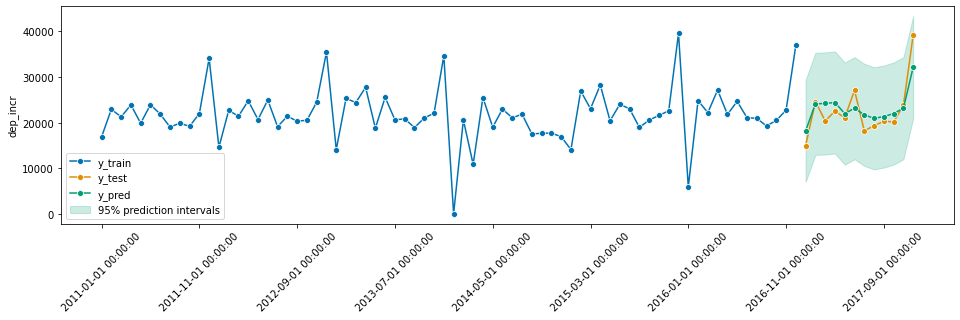

In [633]:
fig, ax = plot_series(transformed_train.set_index('date')['dep_incr'], transformed_test.set_index(y_test['date'])['dep_incr'], df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');
plt.xticks(rotation=45);

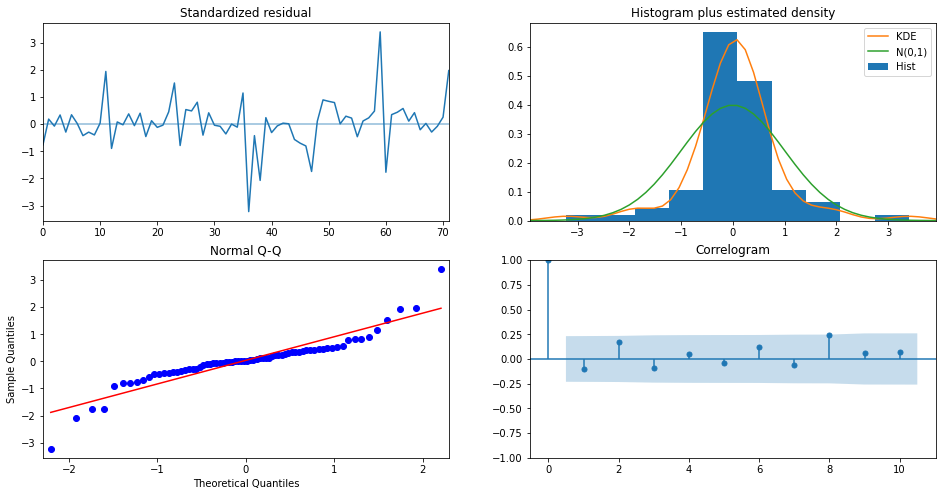

In [634]:
arima_model.plot_diagnostics(figsize=(16,8))
plt.show()

После трансформации данных некоторые метрики стали лучше, это произошло из за того, что данные теперь в другой шкале, также видим, что mase снизилась, она не зависит от масштаба данных. Модель стала хуже описывать данные.

## Sarimax 

В данном моделировании нам необходимо исследовать зависимость динамика прироста вкладов от других макроэкономических показателей.
В первых моделях это выяснить не удавалось, так как мы использовали единственный временной ряд. Поэтому необходимо добавить в нашу модель экзогенные переменные. Для этого используем модель <b>Sarimax</b>, которая их учитывает.

In [635]:
y_train = df.iloc[:72,:2]
y_test = df.iloc[72:,:2]
ex_var = df.drop('dep_incr', axis=1)

ex_var = ex_var.set_index('date')

In [636]:
y_test.dep_incr

72    -154550.0
73     259531.0
74      67600.0
75     162438.0
76      98717.0
77     376724.0
78     -24033.0
79      21879.0
80      65188.0
81      58018.0
82     221114.0
83    1013336.0
Name: dep_incr, dtype: float64

Используем параметры, полученные при тренировке Sarima

In [637]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model = SARIMAX(y_train.set_index('date'), order=(1,0,1), seasonal_order=(1,0,0,12), exog=ex_var.iloc[:72])
sarimax = sarimax_model.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [638]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            dep_incr   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -964.433
Date:                             Fri, 30 Jul 2021   AIC                           1956.866
Time:                                     22:43:13   BIC                           1988.739
Sample:                                 01-01-2011   HQIC                          1969.555
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ofz_profit   -4.109e+04    3.8e+04     -1.081      0.280   -1.16e+05    3.34e+04
key_rate     -2.251e+04    4.8e+04     -0.469      0.639   -1.17e+05    7.15e+04
dep_rate_usd  1.456e+05   3.03e+04      4.806      0.000    8.62e+04    2.05e+05
dep_rate_rub -4.157e+04   3.19e+04     -1.302      0.193   -1.04e+05     2.1e+04
oil_price      878.0021   4375.095      0.201      0.841   -7697.026    9453.031
cpi          -2075.9272   9759.897     -0.213      0.832   -2.12e+04    1.71e+04
m0              -0.2845      0.212     -1.341      0.180      -0.700       0.131
m2               8.8803     56.529      0.157      0.875    -101.915     119.676
dollar_rate   8484.2423   9053.556      0.937      0.349   -9260.401    2.62e+04
nominal_wage    75.5944     15.664      4.826      0.000      44.893     106.295
ar.L1           -0.9987      0.019    -51.842      0.000      -1.036      -0.961
ma.L1            0.9780      0.165      5.927      0.000       0.655       1.301
ar.S.L12         0.0239      0.177      0.135      0.893      -0.323       0.370
sigma2         2.72e+10      0.046   5.95e+11      0.000    2.72e+10    2.72e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                45.64
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -1.19
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+29. Standard errors may be unstable.
"""

 Только переменные <b>dep_rate_usd и nominal_wage</b> оказались статистически значимыми,  p_value < 5%

In [639]:
y_pred = sarimax.predict(72,83, exog=ex_var.iloc[72:])

In [640]:
y_pred

2017-01-01   -1.099924e+05
2017-02-01    8.009280e+04
2017-03-01    1.356321e+05
2017-04-01    2.595289e+05
2017-05-01    2.295499e+05
2017-06-01    4.888912e+05
2017-07-01    5.582436e+04
2017-08-01    1.384281e+05
2017-09-01    9.266209e+04
2017-10-01    2.361165e+05
2017-11-01    1.783113e+05
2017-12-01    1.054207e+06
Freq: MS, Name: predicted_mean, dtype: float64

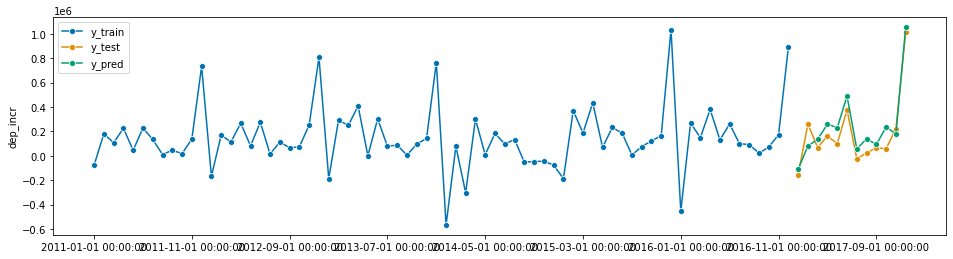

In [641]:
fig, ax = plot_series(y_train.set_index('date')['dep_incr'], y_test.set_index('date')['dep_incr'], y_pred, labels=["y_train", "y_test", "y_pred"]);

In [642]:
print('mape: {}\nmse: {}\nmae: {}\nmase: {}'.format(mape(y_pred.values, y_test.dep_incr),\
                                          mse(y_pred.values, y_test.dep_incr), \
                                          mae(y_pred.values, y_test.dep_incr), \
                                         mase(y_pred.values, y_test.dep_incr, y_train.dep_incr)))

mape: 66.02175427088925
mse: 11156206662.726637
mae: 93147.61777459871
mase: 0.34876625784912285


Экзогенные переменные не улучшили качество, попробуем использовать линейную регрессию


## Linear regression

Наблюдений слишком мало, поэтому time series модели показали себя не очень хорошо.

Используем линейнуюю регресию, она очень легко интерпретируется и показывает неплохие результаты

In [795]:
df.head()

,date,dep_incr,ofz_profit,key_rate,dep_rate_usd,dep_rate_rub,oil_price,cpi,m0,m2,dollar_rate,nominal_wage
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669.0
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680.0
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673.0
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519.0
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779.0


In [796]:
df.describe()

,dep_incr,ofz_profit,key_rate,dep_rate_usd,dep_rate_rub,oil_price,cpi,m0,m2,dollar_rate,nominal_wage
count,8.400000e+01,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,8.400000e+01,84.000000,84.000000,84.000000
mean,1.514771e+05,7.875670,9.130952,2.184643,6.233929,83.118095,136.725747,7.806555e+06,30105.740071,45.288690,31877.130952
std,2.633442e+05,2.195040,2.214233,1.108624,1.733394,30.069987,22.413867,9.703699e+05,6038.007629,15.539177,6029.179510
min,-5.674480e+05,4.558571,5.500000,0.520000,4.000000,30.800000,106.171510,5.532900e+06,19307.700000,27.870000,20669.000000
25%,2.147725e+04,6.228064,8.000000,1.510000,5.292500,51.992500,116.118345,7.139175e+06,24456.950000,31.345000,26830.750000
50%,1.098835e+05,7.475455,8.250000,2.230000,5.755000,99.630000,131.183355,7.959500e+06,30155.450000,35.885000,32355.500000
75%,2.360528e+05,9.332238,10.125000,2.900000,6.657500,110.185000,160.386900,8.462600e+06,35124.050000,59.742500,35772.500000
max,1.034556e+06,15.098421,17.000000,5.220000,12.330000,124.930000,169.560950,9.974472e+06,42372.101217,77.220000,50500.000000


<AxesSubplot:>

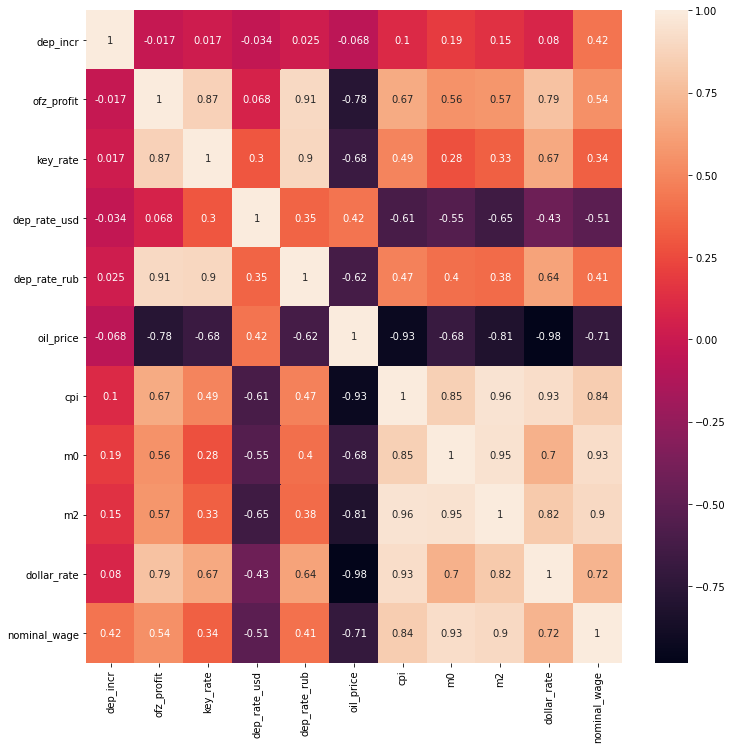

In [797]:
plt.figure(figsize=(12,12))

sns.heatmap(df.corr(), annot=True)

Видно, что в данных присутствует большая мультиколлинеарность, необходимо избавиться от нее, удалив ненужные регрессоры

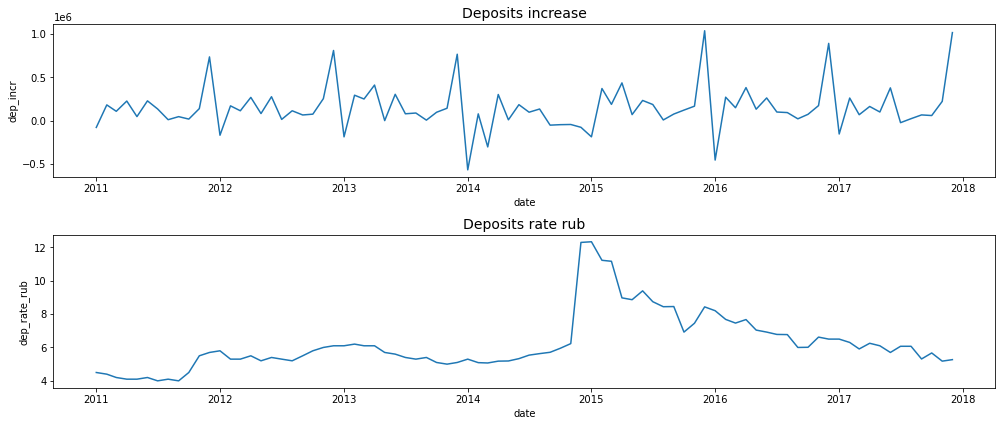

In [798]:

fig, ax = plt.subplots(2, 1, figsize=(14,6))
sns.lineplot(x=df['date'], y=df['dep_incr'], ax=ax[0])
sns.lineplot(x=df['date'], y=df['dep_rate_rub'], ax=ax[1])

ax[0].set_title('Deposits increase',fontsize=14)
ax[1].set_title('Deposits rate rub', fontsize=14)
fig.tight_layout(pad=1.0)

Можно заметить, что основной приток вкладов происходит в декабре, это происходит из за того, что в это время люди обычно получают годовые\квартальные премии, которые впоследствии кладут на вклады.

Найдем реальные доходы населения

In [799]:
df['real_wages'] = df['nominal_wage'] / (df['cpi']/100) ##ипц считаёется к базисному 2010, поэтому можем просто поделить

In [800]:
df[['dep_incr', 'nominal_wage', 'real_wages', 'cpi']].corr()

,dep_incr,nominal_wage,real_wages,cpi
dep_incr,1.000000,0.422482,0.589134,0.102987
nominal_wage,0.422482,1.000000,0.518682,0.839043
real_wages,0.589134,0.518682,1.000000,-0.021789
cpi,0.102987,0.839043,-0.021789,1.000000


Видим, что корреляция реальной зарплаты и прирост депозитов еще выше, чем у номинальной, посмотрим на графике

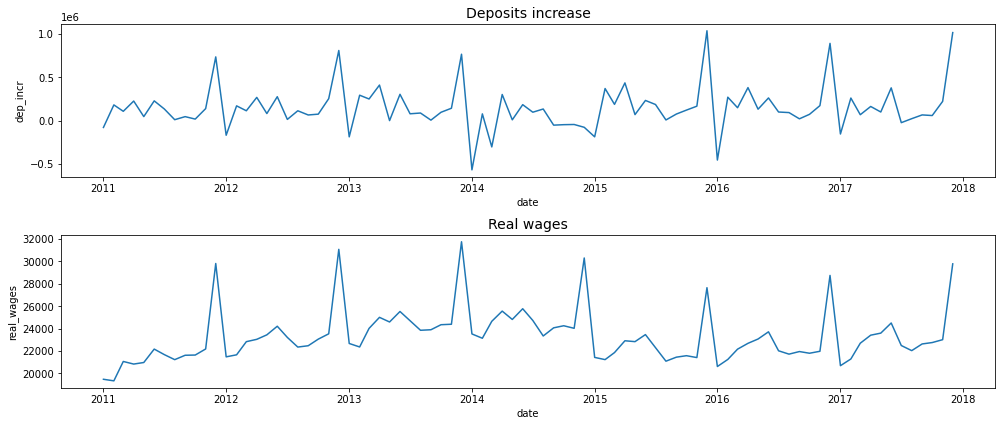

In [801]:
fig, ax = plt.subplots(2, 1, figsize=(14,6))
sns.lineplot(x=df['date'], y=df['dep_incr'], ax=ax[0])
sns.lineplot(x=df['date'], y=df['real_wages'], ax=ax[1])
ax[0].set_title('Deposits increase',fontsize=14)
ax[1].set_title('Real wages', fontsize=14)
fig.tight_layout(pad=1.0)

Данный график подтверждает предыдущие предположения о том, что в декабре обычно происходит прирост зарплат, поэтому прирост вкладов выше.

В качестве еще одной переменной добавим <b>ВВП</b>. Так как он оценивается поквартально, используем upsampling, чтобы увеличить размерность данных, пропуски заполним наивным прогнозом

In [802]:
gdp = pd.read_excel(r'C:\Users\User\Desktop\ввп.xlsx', header=None)
gdp['date'] = pd.date_range('2011-01-01', periods=28, freq='QS')
gdp.columns = ['gdp', 'year', 'date']
gdp = gdp.iloc[:, [0, 2]].set_index('date')
gdp = gdp.gdp.resample('MS').asfreq()

gdp.fillna(method='ffill', inplace=True)

In [803]:
df = df.merge(gdp, on='date', how='left')
df.fillna(method='ffill', inplace=True)

In [804]:
df.head()

,date,dep_incr,ofz_profit,key_rate,dep_rate_usd,dep_rate_rub,oil_price,cpi,m0,m2,dollar_rate,nominal_wage,real_wages,gdp
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669.0,19467.557728,20116.5
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680.0,19327.167830,20116.5
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673.0,21059.223295,20116.5
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519.0,20826.630119,20330.6
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779.0,20966.450366,20330.6


В данных слишком мало наблюдений, именно поэтому arima и sarimax сработали не очень хорошо.

<b>Удалим ненужные фичи во избежание мультиколлинеарности и переобучения модели</b>

cpi - уже включена в real_wages

nominal_wage - уже включена в real_wages

dollar_rate - корреляция практически со всеми фичами

m0 - уже есть агрегатор m2, который включает в себя m0

Важно было оставить переменные dep_rate_usd и nominal_wage, последнюю мы удалили, но так как она является линейной комбинацией cpi и real_wages ничего страшного не произойдет

In [805]:
drop = ['cpi', 'nominal_wage', 'dollar_rate', 'm0']
df.drop(drop,axis=1, inplace=True)

In [806]:
df.head()

,date,dep_incr,ofz_profit,key_rate,dep_rate_usd,dep_rate_rub,oil_price,m2,real_wages,gdp
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,19307.7,19467.557728,20116.5
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,19536.7,19327.167830,20116.5
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,19788.7,21059.223295,20116.5
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,20020.8,20826.630119,20330.6
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,20160.9,20966.450366,20330.6


Изходя из декомпозиции ряда, можно было заметить, что в нем явно присутствуют временные составляющие.

Основные колебания происходят в декабре и январе, поэтому добавим эти месяцы в качестве dummie переменных

In [807]:
df['month'] = df['date'].dt.month
df['is_jun'] = df['month'].apply(lambda x: 1 if x == 1 else 0)
df['is_dec'] = df['month'].apply(lambda x: 1 if x == 12 else 0)
df.drop(['date', 'month'], axis=1, inplace=True)

Стандартизируем данные, чтобы можно было интерпретировать важность экономических факторов

In [808]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df),columns = df.columns)

Сохраним среднее и стандартное отклонение, чтобы впоследствии привести данные к нормальному виду

In [816]:
def inverse_scale(y):
    y_mean = scaler.mean_[0]
    y_std = np.sqrt(scaler.var_[0])
    return (y * y_std) + y_mean

In [812]:
(df.dep_incr * y_std) + y_mean

0      -79049.0
1      180475.0
2      106845.0
3      224890.0
4       45856.0
        ...    
79      21879.0
80      65188.0
81      58018.0
82     221114.0
83    1013336.0
Name: dep_incr, Length: 84, dtype: float64

In [813]:
x_train = df.iloc[:72, 1:]
x_test = df.iloc[72:, 1:]
y_train = df.iloc[:72, 0]
y_test = df.iloc[72:, 0]

In [814]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(x_train, y_train)
pred = reg.predict(df.drop('dep_incr', axis=1))

<AxesSubplot:ylabel='dep_incr'>

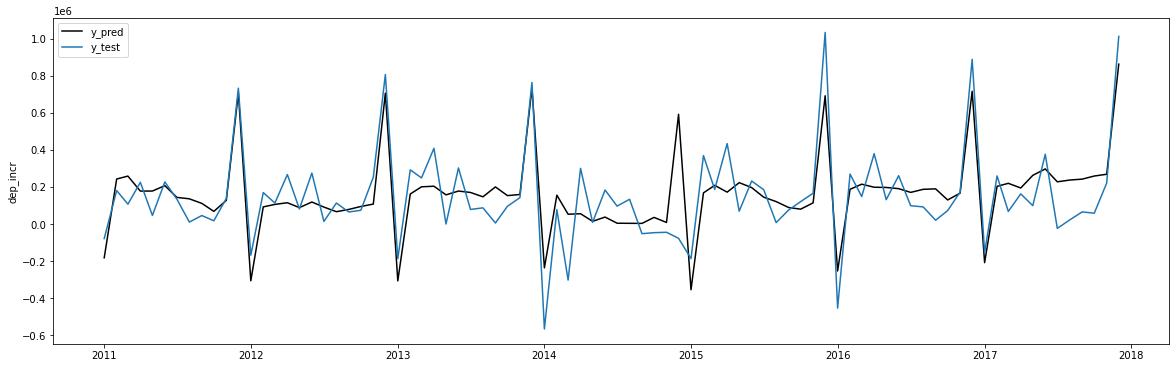

In [817]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.lineplot(x=pd.date_range('2011-01-01', periods=84, freq='MS'), y=inverse_scale(pred), ax=ax, color='black', label='y_pred')
sns.lineplot(x=pd.date_range('2011-01-01', periods=84, freq='MS'), y=inverse_scale(df['dep_incr']), ax=ax, label='y_test')

In [818]:
y_pred = reg.predict(x_test)

In [819]:
print('mape: {}\nmse: {}\nmae: {}\nmase: {}'.format(mape(inverse_scale(y_pred), inverse_scale(y_test))\
                                           ,mse(inverse_scale(y_pred), inverse_scale(y_test))\
                                          , mae(inverse_scale(y_pred), inverse_scale(y_test))\
                                         ,mase(inverse_scale(y_pred), inverse_scale(y_test), inverse_scale(y_train))))

mape: 51.30075833637589
mse: 22464793577.210526
mae: 131699.54217191998
mase: 0.49311359303779206


Добавим остальные месяцы в качестве dummie переменных и построим новую модель

In [820]:
df['month'] = pd.date_range('2011-01-01', periods=84, freq='MS').month
df.drop(['is_jun', 'is_dec'], axis=1, inplace=True)


In [821]:
df = pd.get_dummies(df, columns=['month'])

In [822]:
x_train = df.iloc[:72, 1:]
x_test = df.iloc[72:, 1:]
y_train = df.iloc[:72, 0]
y_test = df.iloc[72:, 0]

In [823]:
reg = LinearRegression(normalize=False)

reg.fit(x_train, y_train)
pred = reg.predict(df.drop('dep_incr', axis=1))

<AxesSubplot:ylabel='dep_incr'>

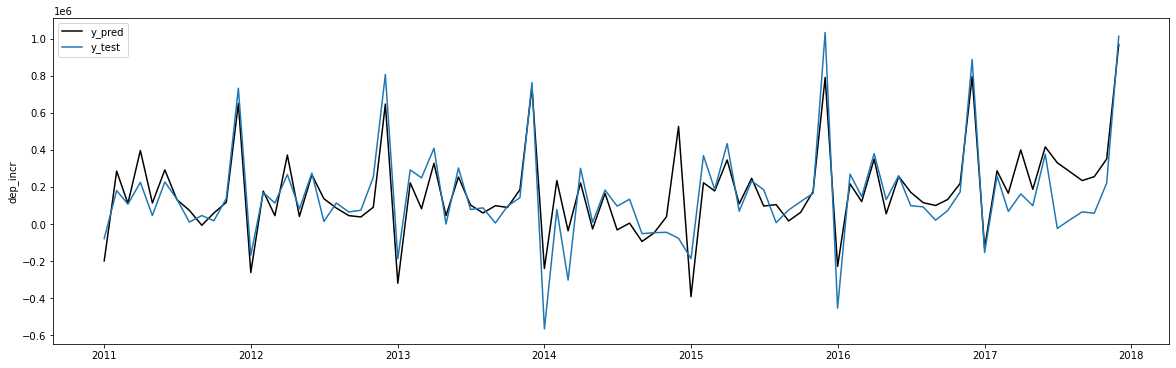

In [824]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.lineplot(x=pd.date_range('2011-01-01', periods=84, freq='MS'), y=inverse_scale(pred), ax=ax, color='black', label='y_pred')
sns.lineplot(x=pd.date_range('2011-01-01', periods=84, freq='MS'), y=inverse_scale(df['dep_incr']), ax=ax, label='y_test')

In [825]:
y_pred = reg.predict(x_test)

In [826]:
print('mape: {}\nmse: {}\nmae: {}\nmase: {}'.format(mape(inverse_scale(y_pred), inverse_scale(y_test))\
                                           ,mse(inverse_scale(y_pred), inverse_scale(y_test))\
                                          , mae(inverse_scale(y_pred), inverse_scale(y_test))\
                                         ,mase(inverse_scale(y_pred), inverse_scale(y_test), inverse_scale(y_train))))

mape: 49.58954322717101
mse: 29743191763.408047
mae: 139341.3225372854
mase: 0.5217261888830526


In [827]:
from sklearn.linear_model import Ridge

reg = Ridge()

reg.fit(x_train, y_train)
pred = reg.predict(df.drop('dep_incr', axis=1))

<AxesSubplot:ylabel='dep_incr'>

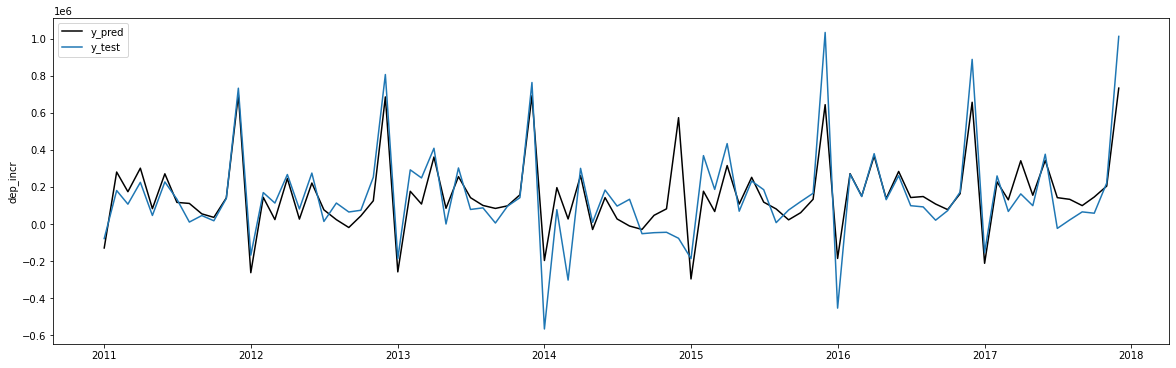

In [828]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.lineplot(x=pd.date_range('2011-01-01', periods=84, freq='MS'), y=inverse_scale(pred), ax=ax, color='black', label='y_pred')
sns.lineplot(x=pd.date_range('2011-01-01', periods=84, freq='MS'), y=inverse_scale(df['dep_incr']), ax=ax, label='y_test')

In [839]:
y_pred = reg.predict(x_test)
print('mape: {}\nmse: {}\nmae: {}\nmase: {}'.format(mape(inverse_scale(y_pred), inverse_scale(y_test))\
                                           ,mse(inverse_scale(y_pred), inverse_scale(y_test))\
                                          , mae(inverse_scale(y_pred), inverse_scale(y_test))\
                                         ,mase(inverse_scale(y_pred), inverse_scale(y_test), inverse_scale(y_train))))

mape: 44.103115419774454
mse: 14317927437.639128
mae: 93057.79918837856
mase: 0.3484299562565571


In [844]:
final_pred = pd.DataFrame({'date':pd.date_range('2017-01-01', periods=12, freq='MS'),'predictions':np.around(inverse_scale(y_pred)), 'real_values':inverse_scale(y_test)})
final_pred

,date,predictions,real_values
72,2017-01-01,-212639.0,-154550.0
73,2017-02-01,227175.0,259531.0
74,2017-03-01,130437.0,67600.0
75,2017-04-01,341416.0,162438.0
76,2017-05-01,155082.0,98717.0
77,2017-06-01,343419.0,376724.0
78,2017-07-01,142084.0,-24033.0
79,2017-08-01,132967.0,21879.0
80,2017-09-01,99153.0,65188.0
81,2017-10-01,145637.0,58018.0


Наилучшей моделью оказалась <b>Ridge</b> регрессия. Она не только показала лучшие результаты практически по всем метрикам, но и очень хорошо аппроксимирует исходный ряд графически. 

Визуализируем регрессоры модели.

In [830]:
coeffs = pd.DataFrame({'coef': x_train.columns, 'values':reg.coef_}).sort_values('values', ascending=False)

Text(0.5, 1.0, 'Feature importances')

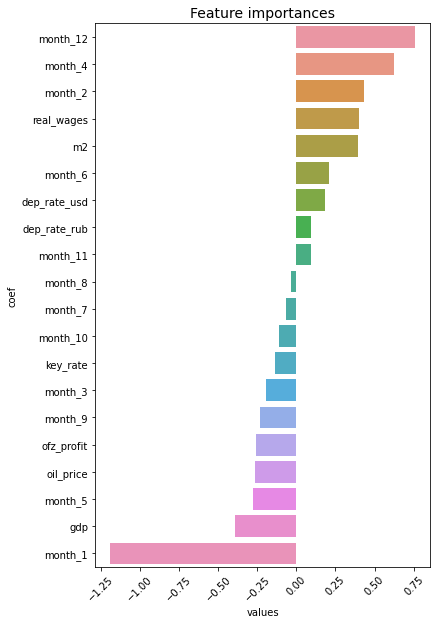

In [833]:
plt.figure(figsize=(6, 10))
sns.barplot(data=coeffs, y='coef', x='values')
plt.xticks(rotation=45);
plt.title('Feature importances', fontsize=14)

Подтверждаются предположения о том, что прирост банковских вкладов в основном зависит от месяца и реальных зарплат населения.

Также для получения более высоких результатов можно использовать 101 форму цб, в которой находятся отчеты по всем банкам банковской системы рф.

Необходимо взвесить ставки банков по оборотам или по притокам средств для каждого банка. (Нампример взять долю притока в сбер, как вес его ставки) и добавить в качестве еще одного регрессора.

Данная идея является очень трудоемкой и не укладывается в срок сдачи работы.